## 1. Test the baseline model

### 1.1 Upload the data and plot the histograms

The key data is in the fiels car_train.csv and cat_test.csv

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np

# import the data
path ='Competitive_Data_Science/data/'
train_data = pd.read_csv(path + 'car_train.csv')
test_data = pd.read_csv(path + 'car_test.csv')

train_data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


array([[<AxesSubplot:title={'center':'car_rating'}>,
        <AxesSubplot:title={'center':'year_to_start'}>,
        <AxesSubplot:title={'center':'riders'}>,
        <AxesSubplot:title={'center':'year_to_work'}>,
        <AxesSubplot:title={'center':'target_reg'}>]], dtype=object)

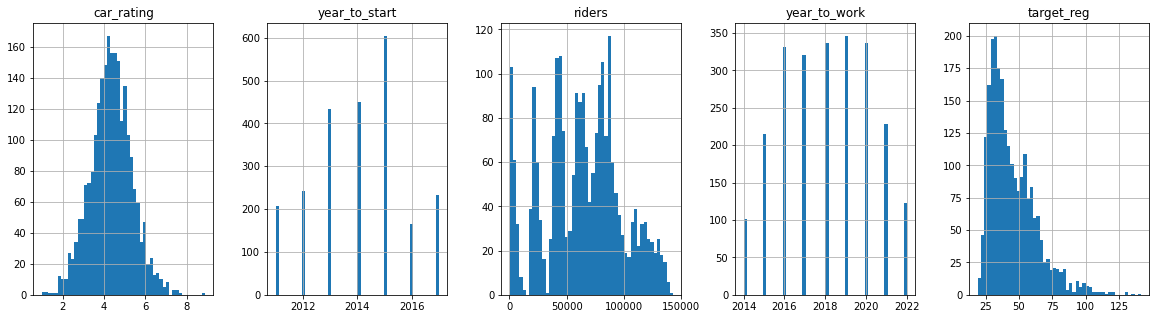

In [2]:
# build the histogram
train_data.hist(layout=(1,5), figsize=(20,5),bins=50) # plots all the numeric features

In [3]:
# output base statistics
train_data.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


### 1.2 Split the design metrix into features(by types) and targets

In [4]:
categorical_features = ['model','car_type','fuel_type']
targets = ['target_reg','target_class']
drop_features = ['car_id']

# split into cat and num 
selected_featurs = [i for i in train_data.columns if (i not in targets and i not in drop_features)] # all besides drop and target
numerical_features = [i for i in selected_featurs if i not in categorical_features]
numerical_features

print('categorical: ', categorical_features, len(categorical_features))
print('numerical: ', numerical_features, len(numerical_features))
print('targets: ', targets, len(targets))

categorical:  ['model', 'car_type', 'fuel_type'] 3
numerical:  ['car_rating', 'year_to_start', 'riders', 'year_to_work'] 4
targets:  ['target_reg', 'target_class'] 2


### 1.3 Train CatBoost on the given features and test accuracy on the test data

In [5]:
#install and import catboost
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [6]:
# split into features and targets/ train and test
X, y = train_data[categorical_features+numerical_features], train_data[targets[1]] #targets[1]== target_class
X_train,X_test, y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

#classifier instance
clf = CatBoostClassifier(cat_features=categorical_features)

#fit
clf.fit(X_train,y_train,
        eval_set=(X_test,y_test),
        plot=True,
        verbose=150)

# inference
y_pred = clf.predict(X_test)
print(f'Accuracy score : {accuracy_score(y_test,y_pred) : 3f}')
#print(f'mean_squared_error : {mean_squared_error(y_test,y_pred) : 3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 321ms	remaining: 5m 20s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 19.4s	remaining: 1m 48s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 56.1s	remaining: 2m 10s
450:	learn: 0.9655173	test: 2.4024298	best: 2.1908935 (6)	total: 1m 11s	remaining: 1m 27s
600:	learn: 0.7488971	test: 2.4913589	best: 2.1908935 (6)	total: 1m 26s	remaining: 57.3s
750:	learn: 0.5826318	test: 2.5762847	best: 2.1908935 (6)	total: 1m 40s	remaining: 33.5s
900:	learn: 0.4643456	test: 2.6651694	best: 2.1908935 (6)	total: 1m 58s	remaining: 13s
999:	learn: 0.4027101	test: 2.7091668	best: 2.1908935 (6)	total: 2m 10s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.
Accuracy score :  0.087607


### 1.4 Save the predicted vals on the hidden test

In [7]:
test_data['target_class'] = clf.predict(test_data[selected_featurs]).ravel() #append new column
test_data[['car_id','target_class']].to_csv('catboost_baseline_v1.csv',index=False)
print("Saved to csv file 'catboost_baseline_v1'")

Saved to csv file 'catboost_baseline_v1'


# 2. Add more features from Rides_Info.csv

🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [8]:
rides_path = 'Competitive_Data_Science/data/rides_info.csv'
rides = pd.read_csv(rides_path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
11669,k47045568e,A19893808P,M1Z,2020-01-07,5.47,22,236,47,79.903189,0,1.032824e+03,0,2.918515,-12.672
331093,P19120611w,X16721605D,r1F,2020-03-18,9.31,40,553,49,85.000000,1,1.655953e+03,0,17.185366,-17.904
132055,R37743900m,J-2100035F,d1S,2020-03-27,3.90,26537,424587,37,67.000000,0,1.000445e+06,0,9.437599,-8.397
161757,W18344113g,L14501903b,c1q,2020-02-28,4.39,43,512,43,78.072271,0,1.555664e+03,0,-4.506163,8.205
349383,F22131987N,Z-1926882U,e1Y,2020-03-28,10.00,27,399,45,79.000000,1,1.173516e+03,0,-11.146999,-24.318


### 2.1 Shrink the data to have only unique cars

Average the respected columns with different statistics for every unique car

In [9]:
f = lambda x: x.nunique() # returns number of unique elements in a Series
print('Number of all logs: ', rides['car_id'].count())
print('Number of unique cars: ', rides['car_id'].nunique())
print("Number of unique rides: ", rides['ride_id'].nunique())
print('Total rides: ', rides['ride_id'].count())
print('total number of driverrs: ',rides.user_id.nunique())

Number of all logs:  739500
Number of unique cars:  4250
Number of unique rides:  2704
Total rides:  739500
total number of driverrs:  15153


In [10]:
rides_df_gr = rides.groupby('car_id', as_index=False).agg(
                mean_rating = ('rating', 'mean'),
                distance_sum = ('distance', 'sum'),
                rating_min = ('rating', 'min'),
                speed_max = ('speed_max', 'max'),
                user_ride_quality_median = ('user_ride_quality', 'median'), 
                deviation_normal_count = ('deviation_normal', 'count'),
                user_uniq = ('user_id', f)
                )

rides_df_gr.head(5)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173
2,A-1162143G,4.662299,2.995194e+06,0.1,180.000000,0.639653,174,172
3,A-1228282M,4.225172,1.793685e+07,0.1,182.446070,-15.663698,174,174
4,A-1339912r,4.690115,1.202552e+07,0.1,152.000000,-9.893439,174,172


In [11]:
train_data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


### 2.2 Add new features about the rides to the initial matrix

In [12]:
def add_features(df):
    if 'mean_rating' not in df.columns:
        new_data = df.merge(rides_df_gr, on='car_id', how='left')
        return new_data
    return df

train = add_features(train_data)
test = add_features(test_data)

print('without rides info: ', train_data.shape)
print('with rides info: ',train.shape)

without rides info:  (2337, 10)
with rides info:  (2337, 17)


In [13]:
train.to_csv('baseline_training_set.csv', index=False)
test.to_csv('baseline_test_set.csv', index=False)

print('Train and test are saved to baseline_.csv')

Train and test are saved to baseline_.csv


### 2.3 Update the categorical and numerical features

In [14]:
rides_df_gr.columns
print(train.columns)
new_cat_features = ['model', 'car_type', 'fuel_type']
features_drop = ['car_id']

new_numeric_features = [i for i in train.columns if i not in new_cat_features + features_drop + targets] 

print('targets: ',len(targets), targets)
print('categorical with rides: ', len(new_cat_features), new_cat_features)
print('numerical with rides: ', len(new_numeric_features), new_numeric_features)


Index(['car_id', 'model', 'car_type', 'fuel_type', 'car_rating',
       'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class',
       'mean_rating', 'distance_sum', 'rating_min', 'speed_max',
       'user_ride_quality_median', 'deviation_normal_count', 'user_uniq'],
      dtype='object')
targets:  2 ['target_reg', 'target_class']
categorical with rides:  3 ['model', 'car_type', 'fuel_type']
numerical with rides:  11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']


### 2.4 Train and evaluate Catboost

In [15]:
X,y = train.drop(targets+['car_id'], axis=1), train.target_class
train_x, test_x, train_y, test_y = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)

clf2 = CatBoostClassifier(cat_features=new_cat_features)
clf2.fit(train_x,train_y,
        eval_set=(test_x,test_y),
        plot=True,
        verbose=100)

pred = clf2.predict(test_x)
print(f'model"s accuracy: {accuracy_score(pred, test_y)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109335
0:	learn: 1.8475119	test: 1.8655808	best: 1.8655808 (0)	total: 127ms	remaining: 2m 6s
100:	learn: 0.3868299	test: 0.5619599	best: 0.5616848 (99)	total: 14s	remaining: 2m 4s
200:	learn: 0.2656284	test: 0.5531493	best: 0.5513186 (167)	total: 25.1s	remaining: 1m 39s
300:	learn: 0.1971982	test: 0.5615205	best: 0.5513186 (167)	total: 37.2s	remaining: 1m 26s
400:	learn: 0.1545483	test: 0.5655797	best: 0.5513186 (167)	total: 47.9s	remaining: 1m 11s
500:	learn: 0.1219900	test: 0.5756722	best: 0.5513186 (167)	total: 59.1s	remaining: 58.9s
600:	learn: 0.0980050	test: 0.5823510	best: 0.5513186 (167)	total: 1m 9s	remaining: 45.9s
700:	learn: 0.0811320	test: 0.5943427	best: 0.5513186 (167)	total: 1m 22s	remaining: 35.3s
800:	learn: 0.0675194	test: 0.6054946	best: 0.5513186 (167)	total: 1m 43s	remaining: 25.6s
900:	learn: 0.0569120	test: 0.6151325	best: 0.5513186 (167)	total: 1m 55s	remaining: 12.7s
999:	learn: 0.0495492	test: 0.6233229	best: 0.5513186 (167)	total: 2m 7

In [16]:
# ouput feature importances
clf2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,36.034645
1,mean_rating,30.903684
2,rating_min,13.938537
3,model,4.206258
4,car_type,3.881288
5,user_uniq,3.035950
6,user_ride_quality_median,2.097702
7,distance_sum,1.614279
8,riders,1.347984
9,car_rating,1.149331


In [17]:
for_test = pd.read_csv('Competitive_Data_Science/data/car_test.csv')
for_test = add_features(for_test)

for_test['target_class'] = clf2.predict(for_test.drop(['car_id'],axis=1)).ravel() #append new column
for_test[['car_id','target_class']].to_csv('catboost_baseline_v2.csv',index=False)
print("Saved to csv file 'catboost_baseline_v2'")

Saved to csv file 'catboost_baseline_v2'


## 3. Add more features

driver_info.csv about drivers  
fix_info.csv about fixes

array([[<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'ride_duration'}>,
        <AxesSubplot:title={'center':'ride_cost'}>,
        <AxesSubplot:title={'center':'speed_avg'}>,
        <AxesSubplot:title={'center':'speed_max'}>],
       [<AxesSubplot:title={'center':'stop_times'}>,
        <AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'refueling'}>,
        <AxesSubplot:title={'center':'user_ride_quality'}>,
        <AxesSubplot:title={'center':'deviation_normal'}>]], dtype=object)

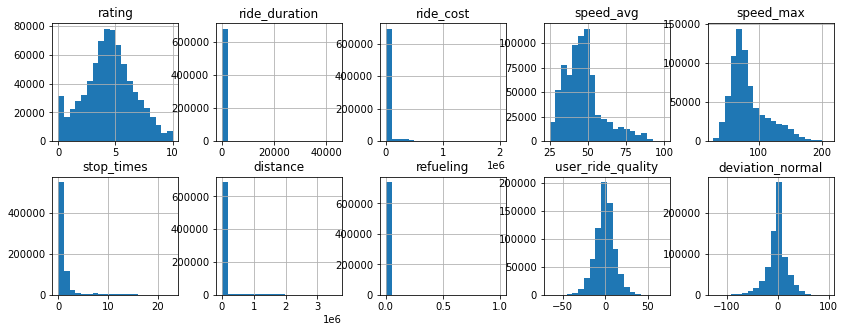

In [18]:
#plot histogram
rides.hist(figsize=(14,5),layout=(2,5), bins=20)

### 3.1 Manual feature engineering for fixes_info

Description of feature columns:

* `worker_id` / `car_id` - идентификатор работника и машины соответственно 
* `work_type` / `work_duration` - тип и длительность (в часах) проводимой работы
* `destroy_degree` - степень износа/поврежденности машины в случае поломки
* `fix_date` - время начала ремонта (время снятия машины с линии)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47
5,O41613818T,RW,2019-2-21 13:25,reparking,1.0,32
6,l-1139189J,PO,2020-3-2 19:11,reparking,1.0,28
7,d-2109686j,ML,2018-3-2 5:12,repair,7.4,39
8,u29695600e,QN,2020-2-2 20:10,reparking,10.0,64
9,U75286923j,KC,2019-9-2 6:32,reparking,1.0,24


array([[<AxesSubplot:title={'center':'destroy_degree'}>,
        <AxesSubplot:title={'center':'work_duration'}>]], dtype=object)

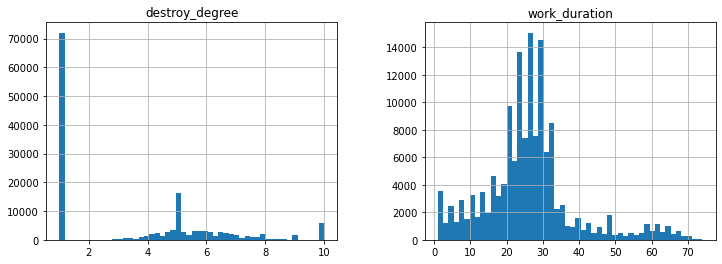

In [19]:
path_fixes = 'Competitive_Data_Science/data/fix_info.csv'
fixes=pd.read_csv(path_fixes)
display(fixes.head(30))
fixes.hist(figsize=(12,4),bins=50)

array([[<AxesSubplot:title={'center':'total_count_of_fixes'}>,
        <AxesSubplot:title={'center':'max_destroy'}>],
       [<AxesSubplot:title={'center':'work_duration_max'}>,
        <AxesSubplot:title={'center':'destroy_degree_std'}>]],
      dtype=object)

,car_id,worker_count,work_duration_mean,work_duration_max,work_duration_std,destroy_degree_std,destroy_degree_sum,work_type_nuniq,work_type_mode,work_type_second_mode,destroy_degree_crit_q
0,A-1049127W,35,27.485714,56,9.735839,2.686474,95.0,4,reparking,repair,1
1,A-1079539w,34,27.382353,64,14.405417,3.066884,147.2,4,repair,reparking,4
2,A-1162143G,34,27.823529,69,14.646275,3.216806,126.0,3,repair,reparking,4
3,A-1228282M,34,24.647059,65,14.131166,1.959958,98.9,4,reparking,repair,0
4,A-1339912r,34,28.617647,71,12.994205,1.988023,103.5,4,repair,reparking,0
...,...,...,...,...,...,...,...,...,...,...,...
4245,z73688663a,35,26.028571,59,8.064029,1.998962,94.7,4,reparking,repair,0
4246,z73740510r,35,25.457143,49,7.620957,2.776704,130.0,3,repair,reparking,0
4247,z86911952C,35,26.942857,48,10.372313,3.069153,119.6,5,reparking,repair,3
4248,z91353693Z,34,28.764706,68,14.785453,3.228236,152.9,4,repair,reparking,3


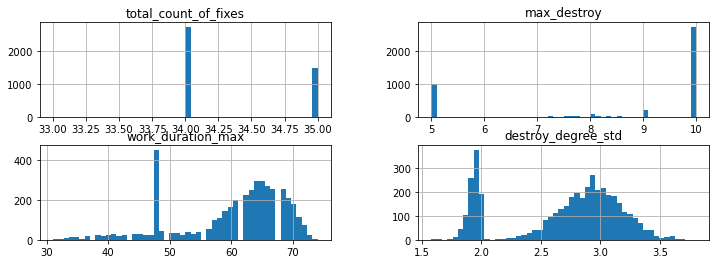

In [20]:
### CUSTOM FUNCTIONS

# num of unique values
f_count = lambda x: x.nunique()

# more than n
more_than_n_func = lambda x,n=8: sum(x > n)

# .3 quantile
def quant_func(x):
    return x.quantile(0.3)

# most often of categorical (modes)
first_mode = lambda x: x.value_counts().index[0]
second_mode = lambda x: x.value_counts().index[1]

### MY FEATURES

fixes_df_gr = fixes.groupby(by='car_id', as_index=False).agg(
    total_count_of_fixes=('fix_date',f_count), # total count of fixes
    max_destroy = ('destroy_degree', 'max'), # max destroy degree
    work_duration_max = ('work_duration', 'max'), # max val of work duration
    destroy_degree_std = ('destroy_degree', 'std')# std deviation of destory degree
)

display(fixes_df_gr.hist(figsize=(12,4), bins=50))


### ELABORATE LIST
 
fixes_gr_v2 = fixes.groupby("car_id", as_index=False).agg(
    
    # Все встроенные статистики
    worker_count=("worker_id", "count"),
    work_duration_mean=("work_duration", "mean"),
    work_duration_max=("work_duration", "max"),
    work_duration_std = ('work_duration','std'),
    destroy_degree_std=("destroy_degree", "std"),
    destroy_degree_sum=("destroy_degree", "sum"),
    
    # Самописные функции для категорий
    work_type_nuniq=("work_type", f_count),
    work_type_mode=("work_type", first_mode),
    work_type_second_mode=("work_type", second_mode),
    
    # Самописные функции для численных
    destroy_degree_crit_q=("destroy_degree", more_than_n_func),
#    worker_quant_exp=("worker_experience", quant_func),
)

fixes_gr_v2.sample(3)
#display(fixes_gr_v2.hist(figsize=(12,4), bins=50))

fixes_gr_v2

In [21]:
train_with_fixes = train.merge(fixes_gr_v2,on='car_id', how='left')
train_with_fixes.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,worker_count,work_duration_mean,work_duration_max,work_duration_std,destroy_degree_std,destroy_degree_sum,work_type_nuniq,work_type_mode,work_type_second_mode,destroy_degree_crit_q
656,S-1468454C,Kia Rio,economy,petrol,4.78,2012,21367,2018,31.16,break_bug,...,35,24.828571,68,14.569278,2.887964,120.0,4,repair,reparking,2
1045,L-4359316J,Smart ForFour,economy,petrol,4.98,2017,119893,2017,37.60,engine_fuel,...,34,26.617647,70,15.135779,3.057879,130.2,4,repair,reparking,3
317,n10768003a,Nissan Qashqai,standart,petrol,4.28,2012,22122,2021,53.91,engine_ignition,...,35,28.257143,63,14.793367,1.885134,123.4,4,repair,reparking,0


### 3.2 See the effect of hand-crafted features onto target prediction
(usin seaborn)

--> destroy_degree standard deviation >> than destroy degree sum  
destroy_degree_std - killer feature

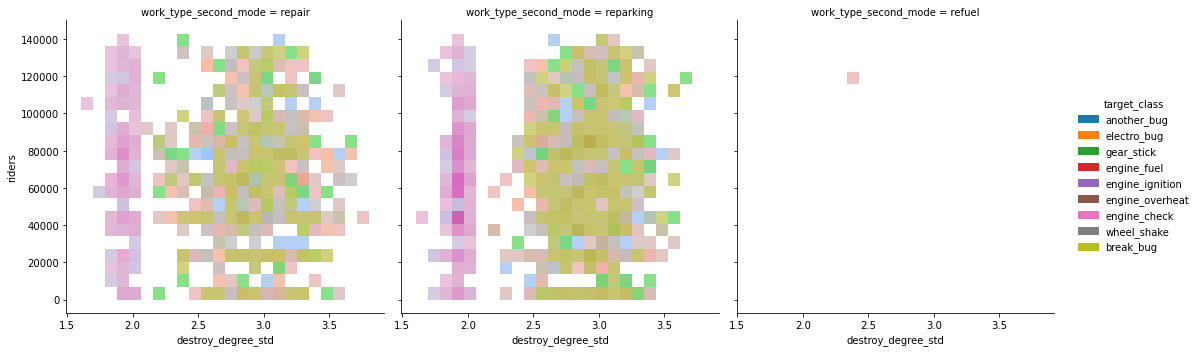

In [22]:
import seaborn as sns

# plot and explore features
g = sns.displot(
    data = train_with_fixes,
    x = 'destroy_degree_std',
    y = 'riders',
    aspect=1,
    kind = 'hist',
    alpha=0.8,
    hue='target_class',
    col='work_type_second_mode',
)

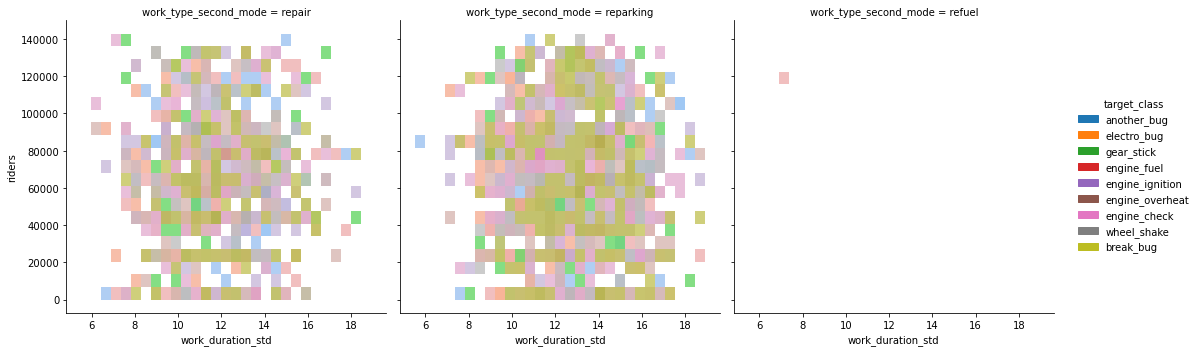

In [23]:
# plot and explore features
g = sns.displot(
    data = train_with_fixes,
    x = 'work_duration_std',
    y = 'riders',
    aspect=1,
    kind = 'hist',
    alpha=0.8,
    hue='target_class',
    col='work_type_second_mode',
)

array([[<AxesSubplot:title={'center':'oil_change_mean'}>,
        <AxesSubplot:title={'center':'refuel_mean'}>,
        <AxesSubplot:title={'center':'refuel_check_mean'}>],
       [<AxesSubplot:title={'center':'refuel_reparking_mean'}>,
        <AxesSubplot:title={'center':'repair_mean'}>,
        <AxesSubplot:title={'center':'reparking_mean'}>],
       [<AxesSubplot:title={'center':'oil_change_count'}>,
        <AxesSubplot:title={'center':'refuel_count'}>,
        <AxesSubplot:title={'center':'refuel_check_count'}>],
       [<AxesSubplot:title={'center':'refuel_reparking_count'}>,
        <AxesSubplot:title={'center':'repair_count'}>,
        <AxesSubplot:title={'center':'reparking_count'}>]], dtype=object)

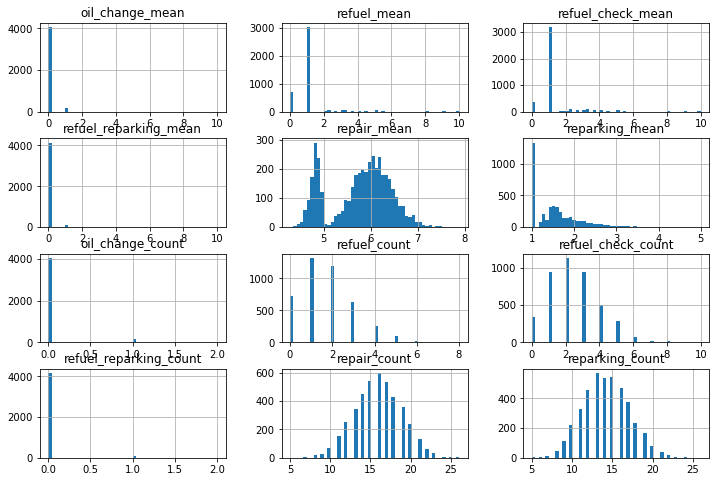

In [24]:
#using pivot
fixes_pivot = pd.pivot_table(fixes,
                       index='car_id', # features
                       columns=['work_type'], # column to make different cols
                       values=['destroy_degree'], #statistics
                       aggfunc=['mean','count']
                       ).fillna(0)

fixes_pivot.columns = [f"{i[2]}_{i[0]}" for i in fixes_pivot.columns]
fixes_pivot.reset_index(inplace=True)

fixes_pivot.hist(figsize=(12,8), bins=50)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
1808,25,9.0,744,20.0,a20462230K,1,2019-5-3
5498,48,8.5,629,1.0,Q70470538U,0,2019-5-30
3958,29,7.6,1107,9.0,M22069362A,1,2020-12-2
3031,44,8.0,965,10.0,S17530853F,0,2021-1-19
7814,28,8.4,933,15.0,n60373030O,1,2018-12-16
11804,31,8.2,22,18.0,N20789692j,1,2020-2-7
13167,50,7.1,1433,11.0,d63483374v,0,2021-5-21
4732,24,9.0,746,14.0,B10466379c,1,2020-8-25
15103,30,7.7,1506,1.0,D51573123d,0,2021-6-11
5072,52,7.8,437,3.0,X19631925T,0,2019-7-21


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'user_rating'}>],
       [<AxesSubplot:title={'center':'user_rides'}>,
        <AxesSubplot:title={'center':'user_time_accident'}>],
       [<AxesSubplot:title={'center':'sex'}>, <AxesSubplot:>]],
      dtype=object)

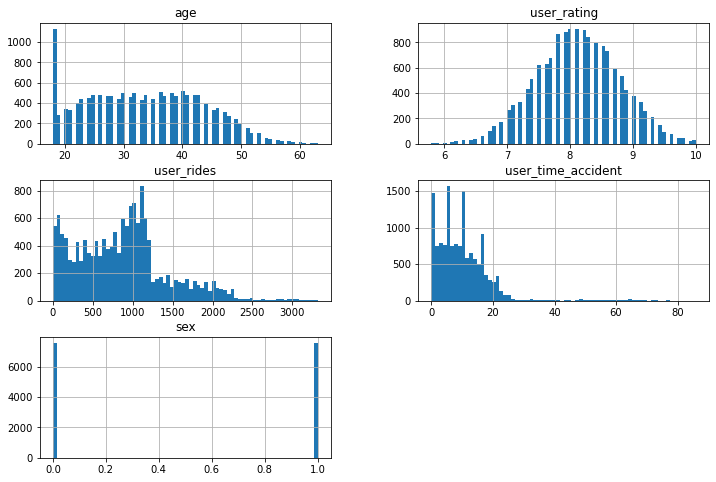

In [25]:
path_drivers= 'Competitive_Data_Science/data/driver_info.csv'
drivers = pd.read_csv(path_drivers)
display(drivers.sample(10))
drivers.hist(figsize=(12,8), bins=70)

### 3.3 Upload and process info about drivers

In [26]:
train_v2 = pd.merge(train_with_fixes, fixes_pivot,on='car_id',how='left')
rides_drivers = pd.merge(rides,drivers,on='user_id', how='left')
rides_drivers.sample(20)
rides_drivers

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909,18,8.0,228,9.0,1,2019-9-16
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133,40,7.0,992,9.0,0,2019-2-26
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461,32,7.7,1646,3.0,1,2018-6-11
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909,35,7.7,1899,8.0,0,2021-9-22
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822,24,7.6,472,1.0,1,2019-7-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,2274.772387,0,6.137593,-39.752,39,7.3,817,3.0,0,2019-4-13
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,515.580231,0,6.703367,-38.480,33,8.0,357,13.0,1,2020-5-15
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,444.846677,0,6.255344,-45.080,18,7.6,1065,8.0,1,2020-11-19
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,179.464361,0,7.759949,-60.193,34,7.9,301,6.0,0,2019-8-26


array([[<AxesSubplot:title={'center':'user_rating_mean'}>,
        <AxesSubplot:title={'center':'male_or_female'}>],
       [<AxesSubplot:title={'center':'user_rides_std'}>,
        <AxesSubplot:title={'center':'user_rides_median'}>],
       [<AxesSubplot:title={'center':'age_mean'}>, <AxesSubplot:>]],
      dtype=object)

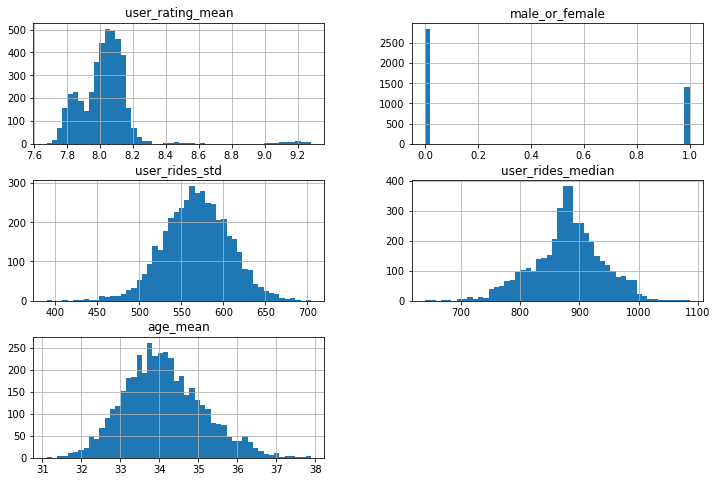

In [27]:
# average rating of the user_id
# most often sex on a car
# std deviation of the number of user rides
# mean user rides
# average age

first_mode = lambda x: x.value_counts().index[0]

rides_drivers_gr = rides_drivers.groupby(by='car_id', as_index=False).agg(
    user_rating_mean = ('user_rating','mean'),
    male_or_female = ('sex',first_mode),
    user_rides_std = ('user_rides', 'std'),
    user_rides_median = ('user_rides', 'median'),
    age_mean = ('age', 'mean')
)
display(rides_drivers_gr.hist(figsize=(12,8), bins=50))


In [28]:
train_v3 = pd.merge(train_v2,rides_drivers_gr, on='car_id',how='left')
train_v3

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,refuel_count,refuel_check_count,refuel_reparking_count,repair_count,reparking_count,user_rating_mean,male_or_female,user_rides_std,user_rides_median,age_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2.0,4.0,0.0,12.0,17.0,8.229885,1,546.505545,804.5,33.511494
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.0,2.0,1.0,13.0,18.0,7.988506,0,585.134416,874.0,34.988506
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,2.0,4.0,1.0,14.0,14.0,7.843103,1,531.541486,991.5,32.839080
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.0,1.0,0.0,17.0,16.0,8.524138,0,514.264373,973.5,34.977011
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,2.0,5.0,0.0,15.0,13.0,8.112069,0,570.284478,885.5,34.298851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,3.0,1.0,0.0,19.0,11.0,8.124138,1,585.379617,895.0,32.632184
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.0,3.0,0.0,9.0,21.0,8.150575,0,539.255588,994.0,34.977011
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,1.0,4.0,0.0,14.0,15.0,7.783908,0,577.150463,815.5,33.287356
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,1.0,3.0,0.0,14.0,16.0,8.084483,1,573.968138,876.5,31.977011


### 3.4 Train Catboost with updated features 17 --> 41

In [29]:
X, y = train_v3.drop(targets+['car_id'], axis=1), train_v3.target_class
X_train, X_test, Y_train,Y_test = train_test_split(X,y, shuffle=True,random_state=42,test_size=0.2)

X_train
cat_ft = ['model', 'car_type', 'fuel_type', 'work_type_mode','work_type_second_mode']
num_ft = [i for i in X.columns if i not in cat_ft]
tg = targets

print('Categorical: ', len(cat_ft), cat_ft)
print('Numerical: ', len(num_ft), num_ft)
print('Targets: ', len(targets), tg)


Categorical:  5 ['model', 'car_type', 'fuel_type', 'work_type_mode', 'work_type_second_mode']
Numerical:  36 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'worker_count', 'work_duration_mean', 'work_duration_max', 'work_duration_std', 'destroy_degree_std', 'destroy_degree_sum', 'work_type_nuniq', 'destroy_degree_crit_q', 'oil_change_mean', 'refuel_mean', 'refuel_check_mean', 'refuel_reparking_mean', 'repair_mean', 'reparking_mean', 'oil_change_count', 'refuel_count', 'refuel_check_count', 'refuel_reparking_count', 'repair_count', 'reparking_count', 'user_rating_mean', 'male_or_female', 'user_rides_std', 'user_rides_median', 'age_mean']
Targets:  2 ['target_reg', 'target_class']


In [30]:
clf3 = CatBoostClassifier(cat_features=cat_ft)

clf3.fit(X_train, Y_train,
        eval_set=(X_test,Y_test),
        plot=True,
        verbose=100)

pred = clf3.predict(X_test)
print(f'model"s accuracy: {accuracy_score(pred, test_y)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.109335
0:	learn: 1.7306508	test: 1.7557295	best: 1.7557295 (0)	total: 184ms	remaining: 3m 3s
100:	learn: 0.0687342	test: 0.1107066	best: 0.1106536 (99)	total: 32.4s	remaining: 4m 47s
200:	learn: 0.0404203	test: 0.0892647	best: 0.0892647 (200)	total: 1m 7s	remaining: 4m 29s
300:	learn: 0.0283076	test: 0.0795798	best: 0.0795798 (300)	total: 1m 40s	remaining: 3m 54s
400:	learn: 0.0205989	test: 0.0753434	best: 0.0752898 (399)	total: 2m 18s	remaining: 3m 26s
500:	learn: 0.0156182	test: 0.0720160	best: 0.0720160 (500)	total: 2m 39s	remaining: 2m 38s
600:	learn: 0.0123378	test: 0.0698231	best: 0.0698222 (599)	total: 3m 8s	remaining: 2m 5s
700:	learn: 0.0104246	test: 0.0697471	best: 0.0693280 (666)	total: 3m 24s	remaining: 1m 27s
800:	learn: 0.0088592	test: 0.0692917	best: 0.0692917 (800)	total: 3m 42s	remaining: 55.3s
900:	learn: 0.0075786	test: 0.0687048	best: 0.0686568 (887)	total: 4m 1s	remaining: 26.5s
999:	learn: 0.0067404	test: 0.0682011	best: 0.0681247 (988)	tota

### 3.5 update the predictions and save

In [31]:
test_path = 'Competitive_Data_Science/data/car_test.csv'
test = pd.read_csv(test_path)
test

# rides_df_gr, fixes_gr_v2,fixes_pivot, rides_drivers_gr - sequence of merges

# upload all the available data to test_data(without targets)
test_1 = test.merge(rides_df_gr, on='car_id', how='left')
test_2 = test_1.merge(fixes_gr_v2, on='car_id', how='left')
test_3 = test_2.merge(fixes_pivot, on='car_id', how='left')
test_4 = test_3.merge(rides_drivers_gr, on='car_id', how='left')
test_fin = test_4.drop(['car_id'], axis=1)
test_fin

#make prediction
pred_fin = clf3.predict(test_fin).ravel()

# save predicted labels
test['target_class'] = pred_fin #append new column
test[['car_id','target_class']].to_csv('catboost_v3.csv',index=False)
print("Saved to csv file 'catboost_v3.csv'")


Saved to csv file 'catboost_v3.csv'
